<a href="https://colab.research.google.com/github/mpHarm88/DS-Unit-2-Regression-Classification/blob/master/module1/Mikio_Harman_assignment_regression_classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 1

## Assignment

You'll use another **New York City** real estate dataset. 

But now you'll **predict how much it costs to rent an apartment**, instead of how much it costs to buy a condo.

The data comes from renthop.com, an apartment listing website.

- [ ] Look at the data. Choose a feature, and plot its relationship with the target.
- [ ] Use scikit-learn for linear regression with one feature. You can follow the [5-step process from Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html#Basics-of-the-API).
- [ ] Define a function to make new predictions and explain the model coefficient.
- [ ] Organize and comment your code.

> [Do Not Copy-Paste.](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit) You must type each of these exercises in, manually. If you copy and paste, you might as well not even do them. The point of these exercises is to train your hands, your brain, and your mind in how to read, write, and see code. If you copy-paste, you are cheating yourself out of the effectiveness of the lessons.

## Stretch Goals
- [ ] Do linear regression with two or more features.
- [ ] Read [The Discovery of Statistical Regression](https://priceonomics.com/the-discovery-of-statistical-regression/)
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 2.1: What Is Statistical Learning?

In [32]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module1')

Reinitialized existing Git repository in /content/.git/


KeyboardInterrupt: ignored

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
# Read New York City apartment rental listing data
import pandas as pd
df = pd.read_csv('../data/apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

In [0]:
# Remove outliers: 
# the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= 1375) & (df['price'] <= 15500) & 
        (df['latitude'] >=40.57) & (df['latitude'] < 40.99) &
        (df['longitude'] >= -74.1) & (df['longitude'] <= -73.38)]

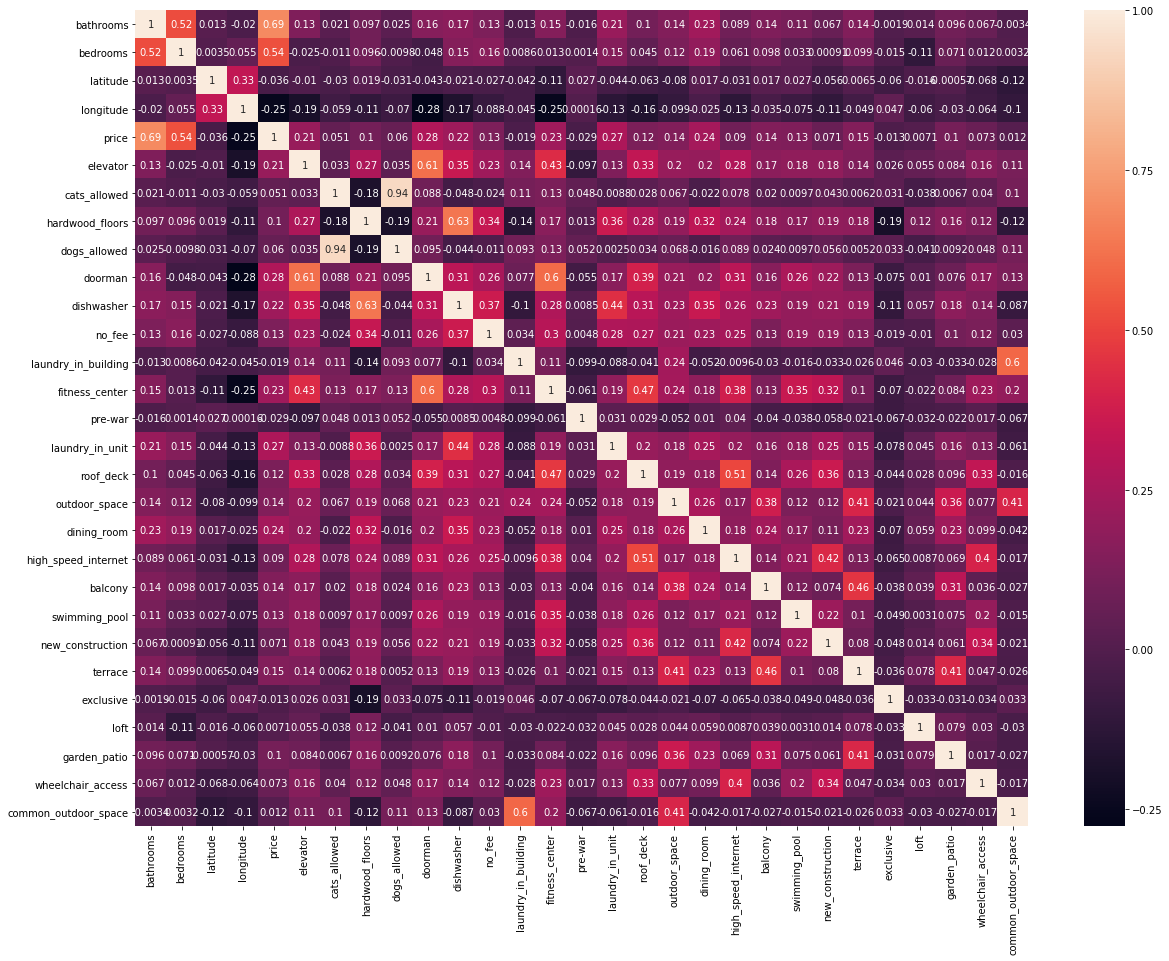

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

#Looking at the correlations
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True)

In [37]:
from sklearn.linear_model import LinearRegression
import plotly.express as px

model = LinearRegression()

features = ['bathrooms']
target = 'price'
X_train = df[features]
y_train = df[target]

model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
#Fitting my line
px.scatter(df, x='bathrooms', y='price', trendline='ols')

In [39]:
#Creating a funcition that predicts the price based on how many bathrooms are present
def predict(x):
  m = model.coef_[0]
  b = model.intercept_
  y = (m*x)+b
  return y, m, b

bathpredict(1)

(3060.278930599848, 2573.3743950844187, 486.9045355154294)

In [44]:
#Model with 2 features
model2 = LinearRegression()
features2 = ['bathrooms', 'bedrooms']
target2 = 'price'
X_train2 = df[features2]
y_train2 = df[target2]

model.fit(X_train2, y_train2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)